#**다음 분기에 어떤 게임을 설계해야 할까**

#**0. Data Description** <br>
* Name : 게임 이름 <br>
* Platform : 게임 지원되는 플랫폼 <br>
* Year : 게임 출시 연도 <br>
* Genre : 게임 장르 <br>
* Publisher : 게임 배급 회사 <br>
* NA_Sales : 북미지역 출고량 <br>
* EU_Sales : 유럽지역 출고량 <br>
* JP_Sales : 일본지역 출고량 <br>
* Other_Sales : 기타지역 출고량 <br>


#**1. 데이터 불러오기**

### 1.1 라이브러리 불러오기

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import random
import math

import scipy
import scipy.stats as stats
from scipy.misc import derivative

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### 1.2 코랩 연결 및 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/vgames2.csv')

In [ ]:
df.head()

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


#**2. 데이터 전처리**

###2.1 Unnamed: 0 coulmn 삭제

In [ ]:
df = df.drop("Unnamed: 0", axis=1)
df.columns

Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales'],
      dtype='object')

###2.2 Year 양식 통일

In [ ]:
years = df.values[:, 2]
years[years < 22] = years[years < 22] + 2000
years[years < 100] = years[years < 100] + 1900
df["Year"] = years

###2.3 Sales 양식 통일

In [ ]:
def convert(series):
    convert = []
    for value in series:
        if 'K' in value or 'k' in value:
            convert.append(int(float(value[:-1]) * 1000))
            continue
        if 'M' in value or 'm' in value:
            convert.append(int(float(value[:-1]) * 1000000))
            continue
        convert.append(int(float(value) * 1000000))
    return convert

###2.4 DataFrame Info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16598 non-null  object
 1   Platform     16598 non-null  object
 2   Year         16327 non-null  object
 3   Genre        16548 non-null  object
 4   Publisher    16540 non-null  object
 5   NA_Sales     16598 non-null  object
 6   EU_Sales     16598 non-null  object
 7   JP_Sales     16598 non-null  object
 8   Other_Sales  16598 non-null  object
dtypes: object(9)
memory usage: 1.1+ MB


###2.5 Missing Value

In [ ]:
df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

###2.6 Missing Value 삭제

In [ ]:
df = df.dropna(axis=0)
print(df.shape)
df.isnull().sum()

(16241, 9)


Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

###2.7 Duplicates 확인

In [ ]:
df.duplicated().sum()

0

###2.8 Dtype 변경

In [ ]:
df["Year"] = df["Year"].astype("int64")
df["NA_Sales"] = convert(df["NA_Sales"])
df["EU_Sales"] = convert(df["EU_Sales"])
df["JP_Sales"] = convert(df["JP_Sales"])
df["Other_Sales"] = convert(df["Other_Sales"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16241 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16241 non-null  object
 1   Platform     16241 non-null  object
 2   Year         16241 non-null  int64 
 3   Genre        16241 non-null  object
 4   Publisher    16241 non-null  object
 5   NA_Sales     16241 non-null  int64 
 6   EU_Sales     16241 non-null  int64 
 7   JP_Sales     16241 non-null  int64 
 8   Other_Sales  16241 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 1.2+ MB


###2.9 index 정렬

In [ ]:
df = df.reset_index(drop=True)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,40000,0,0,0
1,The Munchables,Wii,2009,Action,Namco Bandai Games,170000,0,0,10000
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0,0,20000,0
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,40000,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,120000,90000,0,40000


#**3. 데이터 리스트업**

###3.1 Genre

In [ ]:
df["Genre"].value_counts()

Action          3240
Sports          2299
Misc            1681
Role-Playing    1465
Shooter         1280
Adventure       1268
Racing          1219
Platform         873
Simulation       846
Fighting         835
Strategy         669
Puzzle           566
Name: Genre, dtype: int64

###3.2 Year

In [ ]:
df["Year"].value_counts()

2009    1428
2008    1423
2010    1253
2007    1195
2011    1133
2006    1005
2005     934
2002     826
2003     774
2004     740
2012     652
2015     611
2014     580
2013     545
2001     480
1998     377
2000     348
2016     342
1999     336
1997     289
1996     262
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1984      14
1985      14
1980       8
2017       3
2020       1
Name: Year, dtype: int64

###3.3 Platform

In [ ]:
df["Platform"].value_counts()

DS      2127
PS2     2121
PS3     1299
Wii     1284
X360    1231
PSP     1193
PS      1185
PC       935
XB       799
GBA      784
GC       541
3DS      498
PSV      409
PS4      335
N64      313
SNES     239
XOne     212
SAT      173
WiiU     143
2600     115
NES       98
GB        97
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: Platform, dtype: int64

###3.4 Publisher

In [ ]:
df["Publisher"].value_counts()

Electronic Arts                 1332
Activision                       963
Namco Bandai Games               924
Ubisoft                          913
Konami Digital Entertainment     821
                                ... 
Marvelous Games                    1
Panther Software                   1
Playmore                           1
mixi, Inc                          1
Mystique                           1
Name: Publisher, Length: 575, dtype: int64

### 3.5 Total_Sales 생성

In [ ]:
df["Total_Sales"] = df["NA_Sales"] + df["EU_Sales"] + df["JP_Sales"] + df["Other_Sales"]
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,40000,0,0,0,40000
1,The Munchables,Wii,2009,Action,Namco Bandai Games,170000,0,0,10000,180000
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0,0,20000,0,20000
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,40000,0,0,0,40000
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,120000,90000,0,40000,250000


#**4. 지역에 따라서 선호하는 게임 회사가 다를까**

###4.1 지역별 전체 연도 회사 Top 6 (DataFrame)

#####4.1.1 북미 게임 회사 순위

In [ ]:
df_Publisher_NA = df.groupby(["Publisher"])["NA_Sales", "Total_Sales"].sum().reset_index(drop=False)
df_Publisher_NA = df_Publisher_NA.sort_values(by=["NA_Sales"], ascending=[False]).reset_index(drop=True)
df_Publisher_NA_bar_all = df_Publisher_NA.iloc[:6]
df_Publisher_NA_bar_all

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Publisher,NA_Sales,Total_Sales
0,Nintendo,808139997,1759579992
1,Electronic Arts,579899993,1087179992
2,Activision,425100000,719359998
3,Sony Computer Entertainment,263699997,603579994
4,Ubisoft,252259998,472699998
5,Take-Two Interactive,220460000,398569997


#####4.1.2 유럽 게임 회사 순위

In [ ]:
df_Publisher_EU = df.groupby(["Publisher"])["EU_Sales", "Total_Sales"].sum().reset_index(drop=False)
df_Publisher_EU = df_Publisher_EU.sort_values(by=["EU_Sales"], ascending=[False]).reset_index(drop=True)
df_Publisher_EU_bar_all = df_Publisher_EU.iloc[:6]
df_Publisher_EU_bar_all

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Publisher,EU_Sales,Total_Sales
0,Nintendo,410339997,1759579992
1,Electronic Arts,366110000,1087179992
2,Activision,213169998,719359998
3,Sony Computer Entertainment,186739997,603579994
4,Ubisoft,162990000,472699998
5,Take-Two Interactive,117159998,398569997


#####4.1.3 일본 게임 회사 순위

In [ ]:
df_Publisher_JP = df.groupby(["Publisher"])["JP_Sales", "Total_Sales"].sum().reset_index(drop=False)
df_Publisher_JP = df_Publisher_JP.sort_values(by=["JP_Sales"], ascending=[False]).reset_index(drop=True)
df_Publisher_JP_bar_all = df_Publisher_JP.iloc[:6]
df_Publisher_JP_bar_all

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Publisher,JP_Sales,Total_Sales
0,Nintendo,447429999,1759579992
1,Namco Bandai Games,126699999,252799999
2,Konami Digital Entertainment,90930000,277889998
3,Sony Computer Entertainment,73720000,603579994
4,Capcom,67380000,199810000
5,Sega,55570000,269560000


#####4.1.4 기타 게임 회사 순위

In [ ]:
df_Publisher_Oth = df.groupby(["Publisher"])["Other_Sales", "Total_Sales"].sum().reset_index(drop=False)
df_Publisher_Oth = df_Publisher_Oth.sort_values(by=["Other_Sales"], ascending=[False]).reset_index(drop=True)
df_Publisher_Oth_bar_all = df_Publisher_Oth.iloc[:6]
df_Publisher_Oth_bar_all

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Publisher,Other_Sales,Total_Sales
0,Electronic Arts,127189999,1087179992
1,Nintendo,93669999,1759579992
2,Sony Computer Entertainment,79420000,603579994
3,Activision,74550000,719359998
4,Take-Two Interactive,55119999,398569997
5,Ubisoft,50120000,472699998


### 4.2 지역별 전체 연도 회사 Top 6 (Barplot)

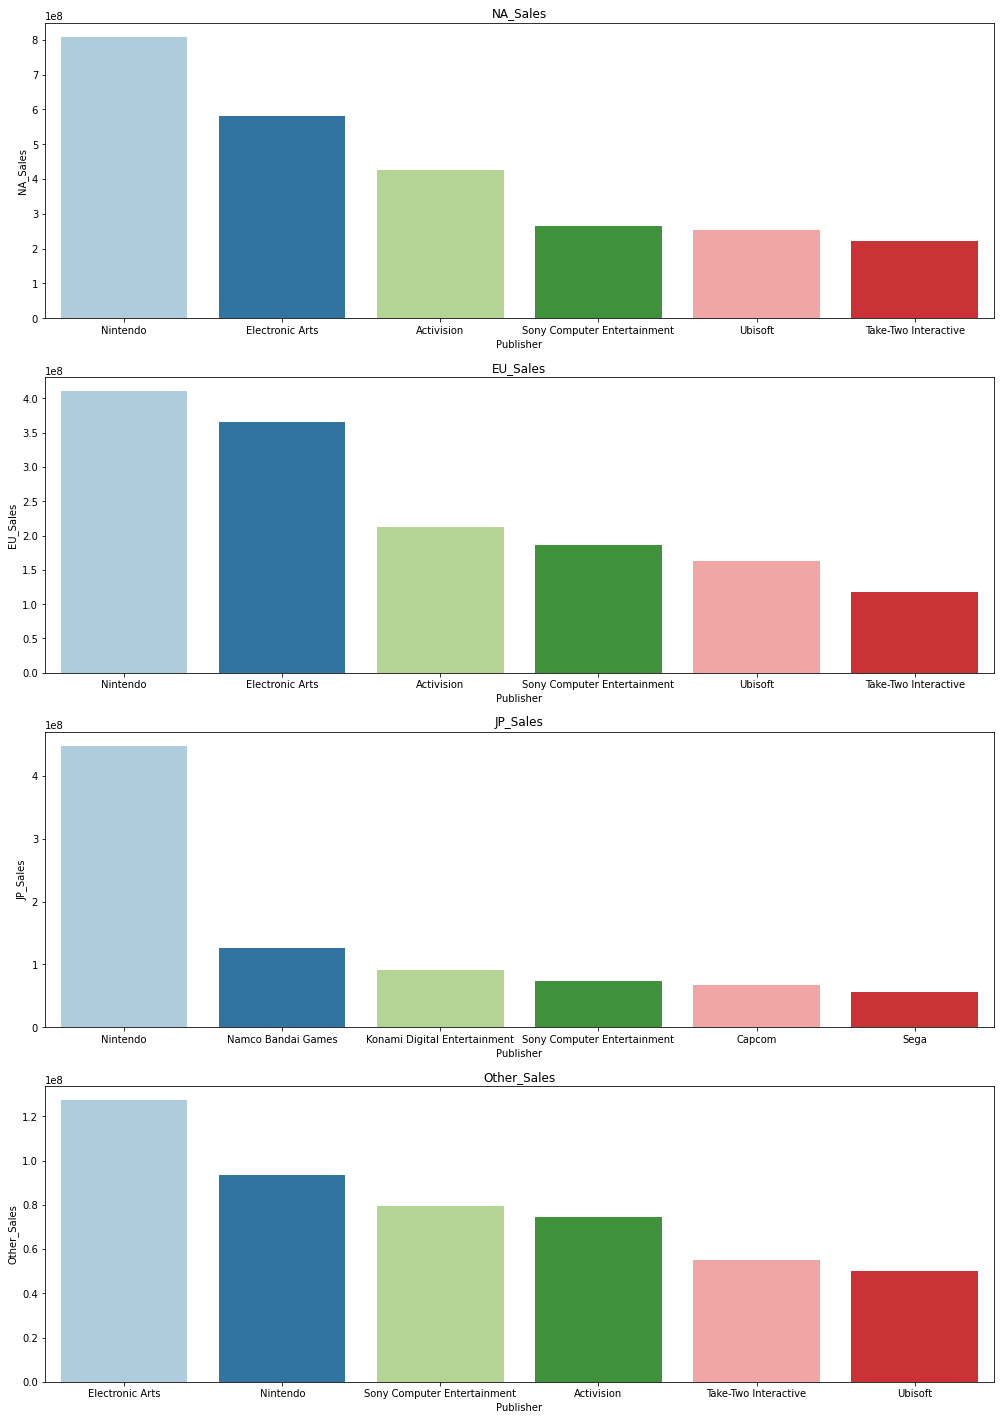

In [ ]:
fig = plt.figure(figsize=(17, 25))
ax = fig.add_subplot(4,1,1)
plt.title("NA_Sales")
sns.barplot(data=df_Publisher_NA_bar_all, x="Publisher", y="NA_Sales", palette="Paired")

ax = fig.add_subplot(4,1,2)
plt.title("EU_Sales")
sns.barplot(data=df_Publisher_EU_bar_all, x="Publisher", y="EU_Sales", palette="Paired")

ax = fig.add_subplot(4,1,3)
plt.title("JP_Sales")
sns.barplot(data=df_Publisher_JP_bar_all, x="Publisher", y="JP_Sales", palette="Paired")

ax = fig.add_subplot(4,1,4)
plt.title("Other_Sales")
sns.barplot(data=df_Publisher_Oth_bar_all, x="Publisher", y="Other_Sales", palette="Paired")

### 4.3 최근 10년 회사 Top 6 (DataFrame)

##### 4.3.1 북미 게임 회사 순위

In [ ]:
df_Publisher_NA = df[df["Year"]>=2010].groupby(["Publisher"])["NA_Sales", "Total_Sales"].sum().reset_index(drop=False)
df_Publisher_NA = df_Publisher_NA.sort_values(by=["NA_Sales"], ascending=[False]).reset_index(drop=True)
df_Publisher_NA_bar_top = df_Publisher_NA.iloc[:6]
df_Publisher_NA_bar_top

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Publisher,NA_Sales,Total_Sales
0,Activision,157900000,294409998
1,Electronic Arts,155299998,360389997
2,Nintendo,105719998,278249997
3,Ubisoft,105269999,220139999
4,Take-Two Interactive,95280000,176059998
5,Microsoft Game Studios,77690000,123870000


##### 4.3.2 유럽 게임 회사 순위

In [ ]:
df_Publisher_EU = df[df["Year"]>=2010].groupby(["Publisher"])["EU_Sales", "Total_Sales"].sum().reset_index(drop=False)
df_Publisher_EU = df_Publisher_EU.sort_values(by=["EU_Sales"], ascending=[False]).reset_index(drop=True)
df_Publisher_EU_bar_top = df_Publisher_EU.iloc[:6]
df_Publisher_EU_bar_top

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Publisher,EU_Sales,Total_Sales
0,Electronic Arts,153320000,360389997
1,Activision,98569998,294409998
2,Ubisoft,85960000,220139999
3,Nintendo,73289999,278249997
4,Take-Two Interactive,55919999,176059998
5,Sony Computer Entertainment,44899999,121909999


##### 4.3.3 일본 게임 회사 순위

In [ ]:
df_Publisher_JP = df[df["Year"]>=2010].groupby(["Publisher"])["JP_Sales", "Total_Sales"].sum().reset_index(drop=False)
df_Publisher_JP = df_Publisher_JP.sort_values(by=["JP_Sales"], ascending=[False]).reset_index(drop=True)
df_Publisher_JP_bar_top = df_Publisher_JP.iloc[:6]
df_Publisher_JP_bar_top

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Publisher,JP_Sales,Total_Sales
0,Nintendo,81710000,278249997
1,Namco Bandai Games,44570000,95290000
2,Capcom,22040000,52220000
3,Square Enix,20250000,76930000
4,Konami Digital Entertainment,18030000,54720000
5,Level 5,11250000,11760000


##### 4.3.4 기타 게임 회사 순위

In [ ]:
df_Publisher_Oth = df[df["Year"]>=2010].groupby(["Publisher"])["Other_Sales", "Total_Sales"].sum().reset_index(drop=False)
df_Publisher_Oth = df_Publisher_Oth.sort_values(by=["Other_Sales"], ascending=[False]).reset_index(drop=True)
df_Publisher_Oth_bar_top = df_Publisher_Oth.iloc[:6]
df_Publisher_Oth_bar_top

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Publisher,Other_Sales,Total_Sales
0,Electronic Arts,47749999,360389997
1,Activision,33750000,294409998
2,Ubisoft,26220000,220139999
3,Take-Two Interactive,21979999,176059998
4,Sony Computer Entertainment,18940000,121909999
5,Nintendo,17530000,278249997


### 4.4 지역별 최근 10년 회사 Top 6 (Barplot)

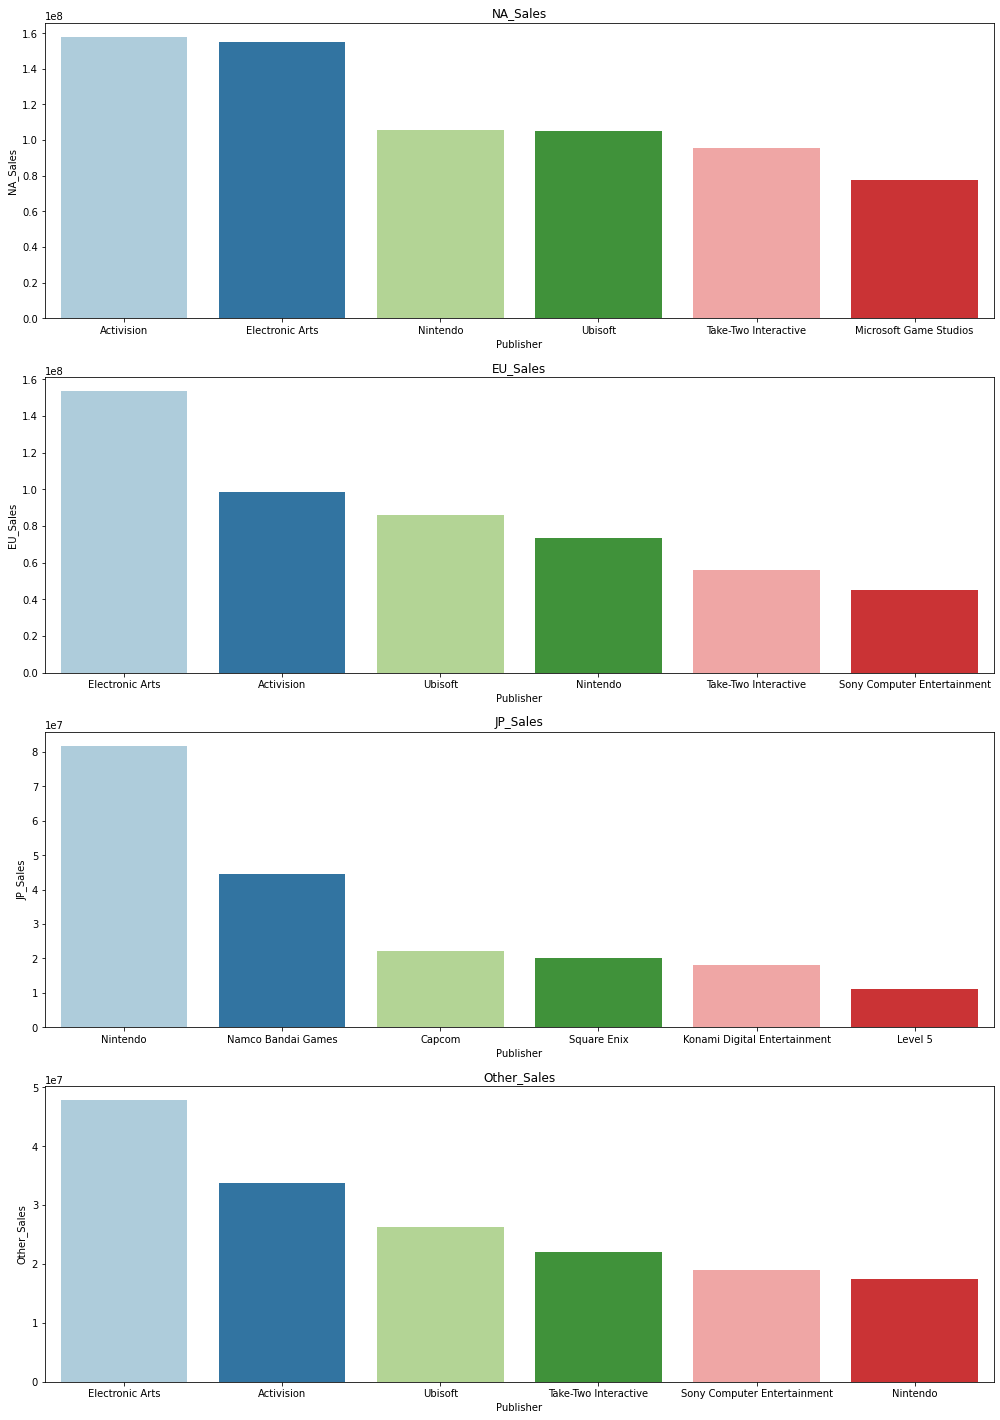

In [ ]:
fig = plt.figure(figsize=(17, 25))
ax = fig.add_subplot(4,1,1)
plt.title("NA_Sales")
sns.barplot(data=df_Publisher_NA_bar_top, x="Publisher", y="NA_Sales", palette="Paired")

ax = fig.add_subplot(4,1,2)
plt.title("EU_Sales")
sns.barplot(data=df_Publisher_EU_bar_top, x="Publisher", y="EU_Sales", palette="Paired")

ax = fig.add_subplot(4,1,3)
plt.title("JP_Sales")
sns.barplot(data=df_Publisher_JP_bar_top, x="Publisher", y="JP_Sales", palette="Paired")

ax = fig.add_subplot(4,1,4)
plt.title("Other_Sales")
sns.barplot(data=df_Publisher_Oth_bar_top, x="Publisher", y="Other_Sales", palette="Paired")

### 4.5 지역별 전체 연도, 최근 10년 회사 선호 변화 (Subplot)

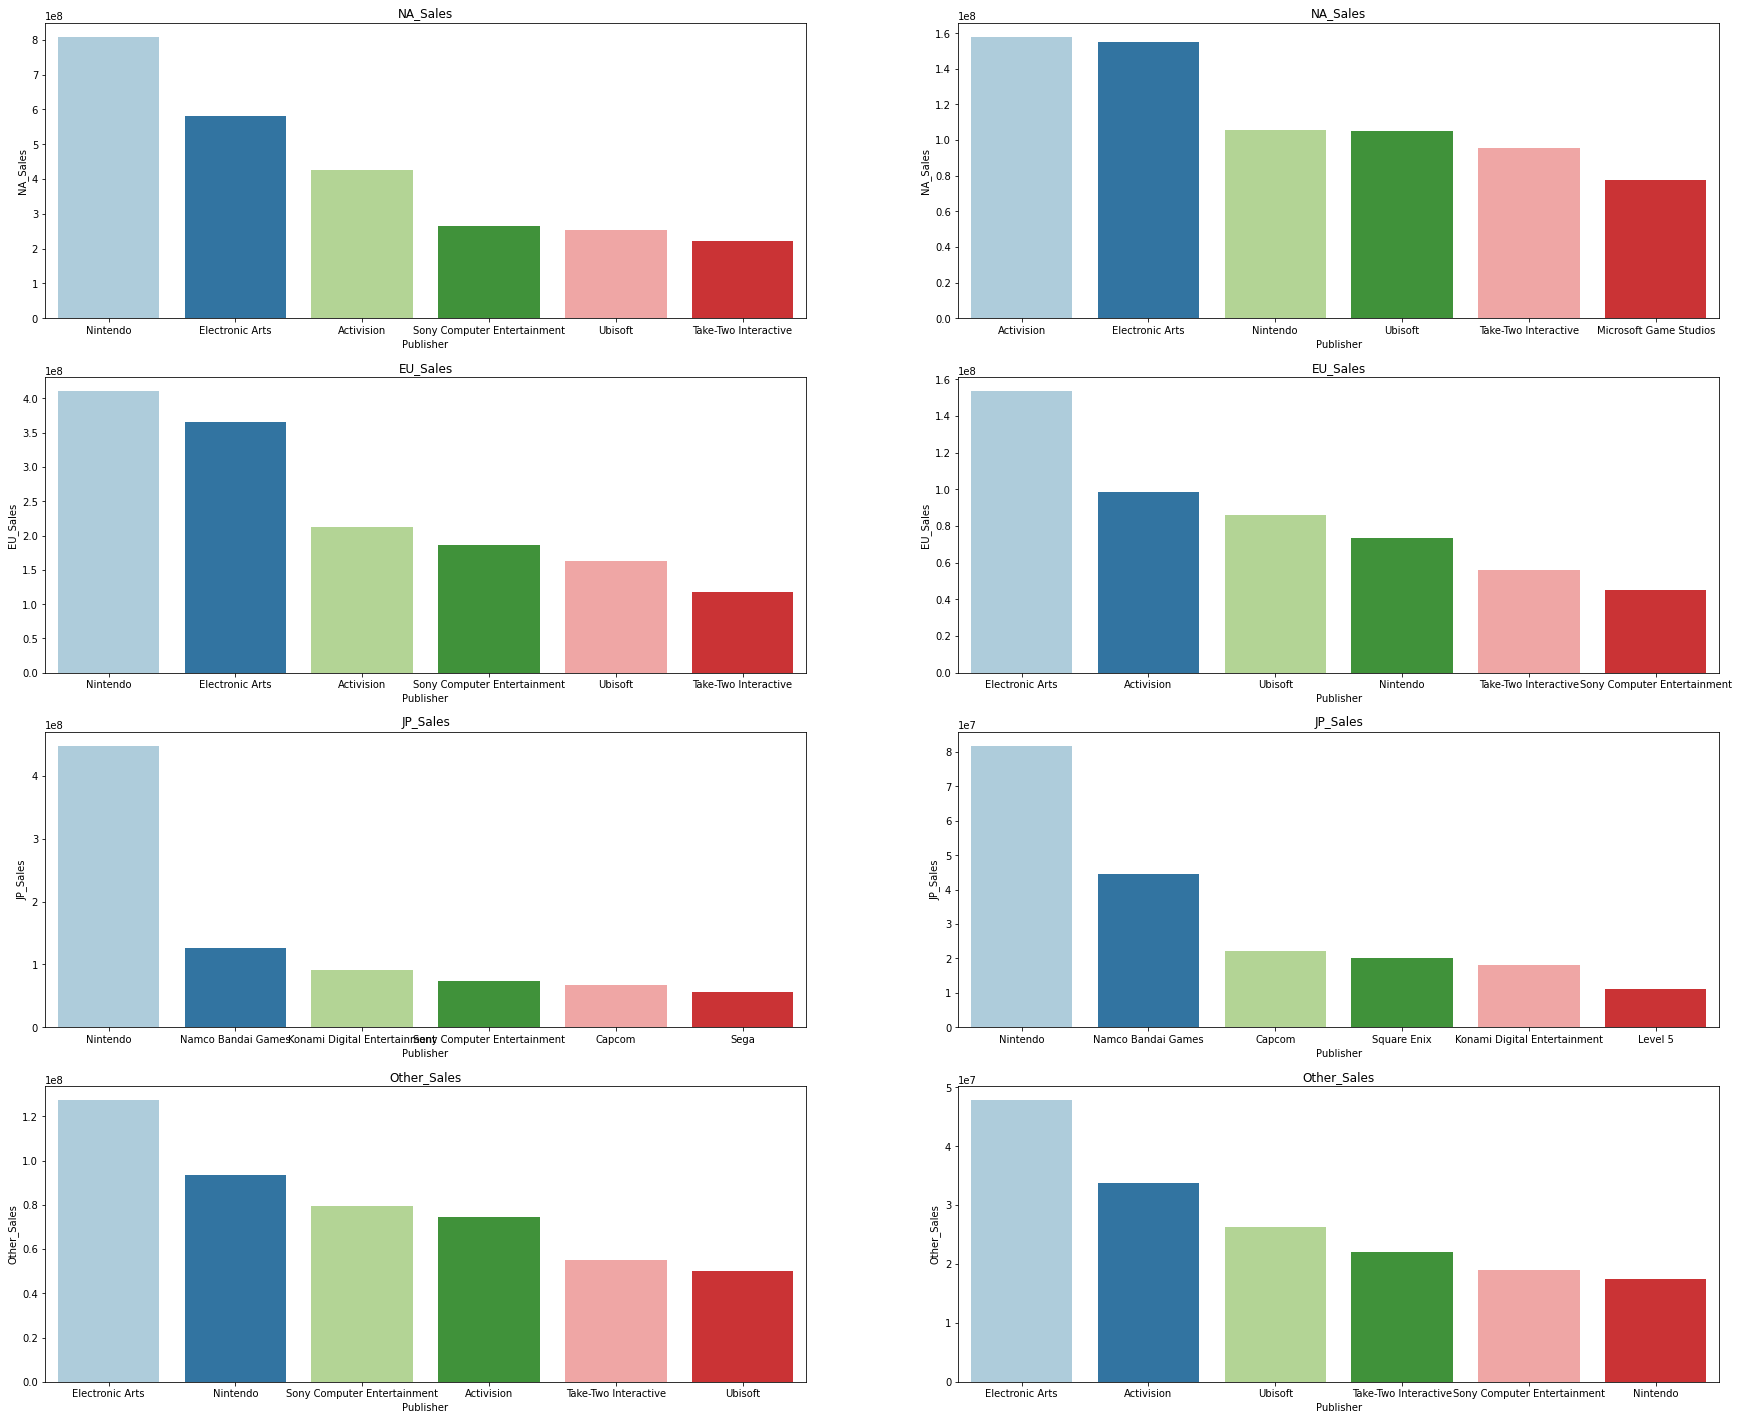

In [ ]:
fig = plt.figure(figsize=(30, 25))
ax = fig.add_subplot(4,2,1)
plt.title("NA_Sales")
sns.barplot(data=df_Publisher_NA_bar_all, x="Publisher", y="NA_Sales", palette="Paired")

ax = fig.add_subplot(4,2,2)
plt.title("NA_Sales")
sns.barplot(data=df_Publisher_NA_bar_top, x="Publisher", y="NA_Sales", palette="Paired")

ax = fig.add_subplot(4,2,3)
plt.title("EU_Sales")
sns.barplot(data=df_Publisher_EU_bar_all, x="Publisher", y="EU_Sales", palette="Paired")

ax = fig.add_subplot(4,2,4)
plt.title("EU_Sales")
sns.barplot(data=df_Publisher_EU_bar_top, x="Publisher", y="EU_Sales", palette="Paired")

ax = fig.add_subplot(4,2,5)
plt.title("JP_Sales")
sns.barplot(data=df_Publisher_JP_bar_all, x="Publisher", y="JP_Sales", palette="Paired")

ax = fig.add_subplot(4,2,6)
plt.title("JP_Sales")
sns.barplot(data=df_Publisher_JP_bar_top, x="Publisher", y="JP_Sales", palette="Paired")

ax = fig.add_subplot(4,2,7)
plt.title("Other_Sales")
sns.barplot(data=df_Publisher_Oth_bar_all, x="Publisher", y="Other_Sales", palette="Paired")

ax = fig.add_subplot(4,2,8)
plt.title("Other_Sales")
sns.barplot(data=df_Publisher_Oth_bar_top, x="Publisher", y="Other_Sales", palette="Paired")

#**5.지역에 따라서 선호하는 게임 장르가 다를까**

### 5.1 지역별 전체 연도 장르 TOP (DataFrame)

#####5.1.1 북미 게임 장르 순위

In [ ]:
df_Genre_NA = df.groupby(["Genre"])["NA_Sales"].sum().reset_index(drop=False)
df_Genre_NA = df_Genre_NA.sort_values(by=["NA_Sales"], ascending=[False]).reset_index(drop=True)
df_Genre_NA

,Genre,NA_Sales
0,Action,858749997
1,Sports,667259996
2,Shooter,574479997
3,Platform,445379999
4,Misc,394729999
5,Racing,354699997
6,Role-Playing,318759999
7,Fighting,220349998
8,Simulation,181429998
9,Puzzle,121579999


#####5.1.2 유럽 게임 장르 순위

In [ ]:
df_Genre_EU = df.groupby(["Genre"])["EU_Sales"].sum().reset_index(drop=False)
df_Genre_EU = df_Genre_EU.sort_values(by=["EU_Sales"], ascending=[False]).reset_index(drop=True)
df_Genre_EU

,Genre,EU_Sales
0,Action,513639997
1,Sports,370969999
2,Shooter,310229996
3,Racing,235019999
4,Misc,208150000
5,Platform,200629999
6,Role-Playing,183089998
7,Simulation,112990000
8,Fighting,99900000
9,Adventure,63660000


#####5.1.3 일본 게임 장르 순위

In [ ]:
df_Genre_JP = df.groupby(["Genre"])["JP_Sales"].sum().reset_index(drop=False)
df_Genre_JP = df_Genre_JP.sort_values(by=["JP_Sales"], ascending=[False]).reset_index(drop=True)
df_Genre_JP

,Genre,JP_Sales
0,Role-Playing,342929999
1,Action,156600000
2,Sports,134759999
3,Platform,130529999
4,Misc,104180000
5,Fighting,87140000
6,Simulation,63540000
7,Racing,56320000
8,Puzzle,56240000
9,Adventure,51870000


#####5.1.4 기타 게임 장르 순위

In [ ]:
df_Genre_Oth = df.groupby(["Genre"])["Other_Sales"].sum().reset_index(drop=False)
df_Genre_Oth = df_Genre_Oth.sort_values(by=["Other_Sales"], ascending=[False]).reset_index(drop=True)
df_Genre_Oth

,Genre,Other_Sales
0,Action,183989998
1,Sports,132349999
2,Shooter,101860000
3,Racing,76510000
4,Misc,72639999
5,Role-Playing,56730000
6,Platform,51450000
7,Fighting,36150000
8,Simulation,31320000
9,Adventure,16700000


### 5.2 지역별 전체 연도 장르 TOP (Barplot)

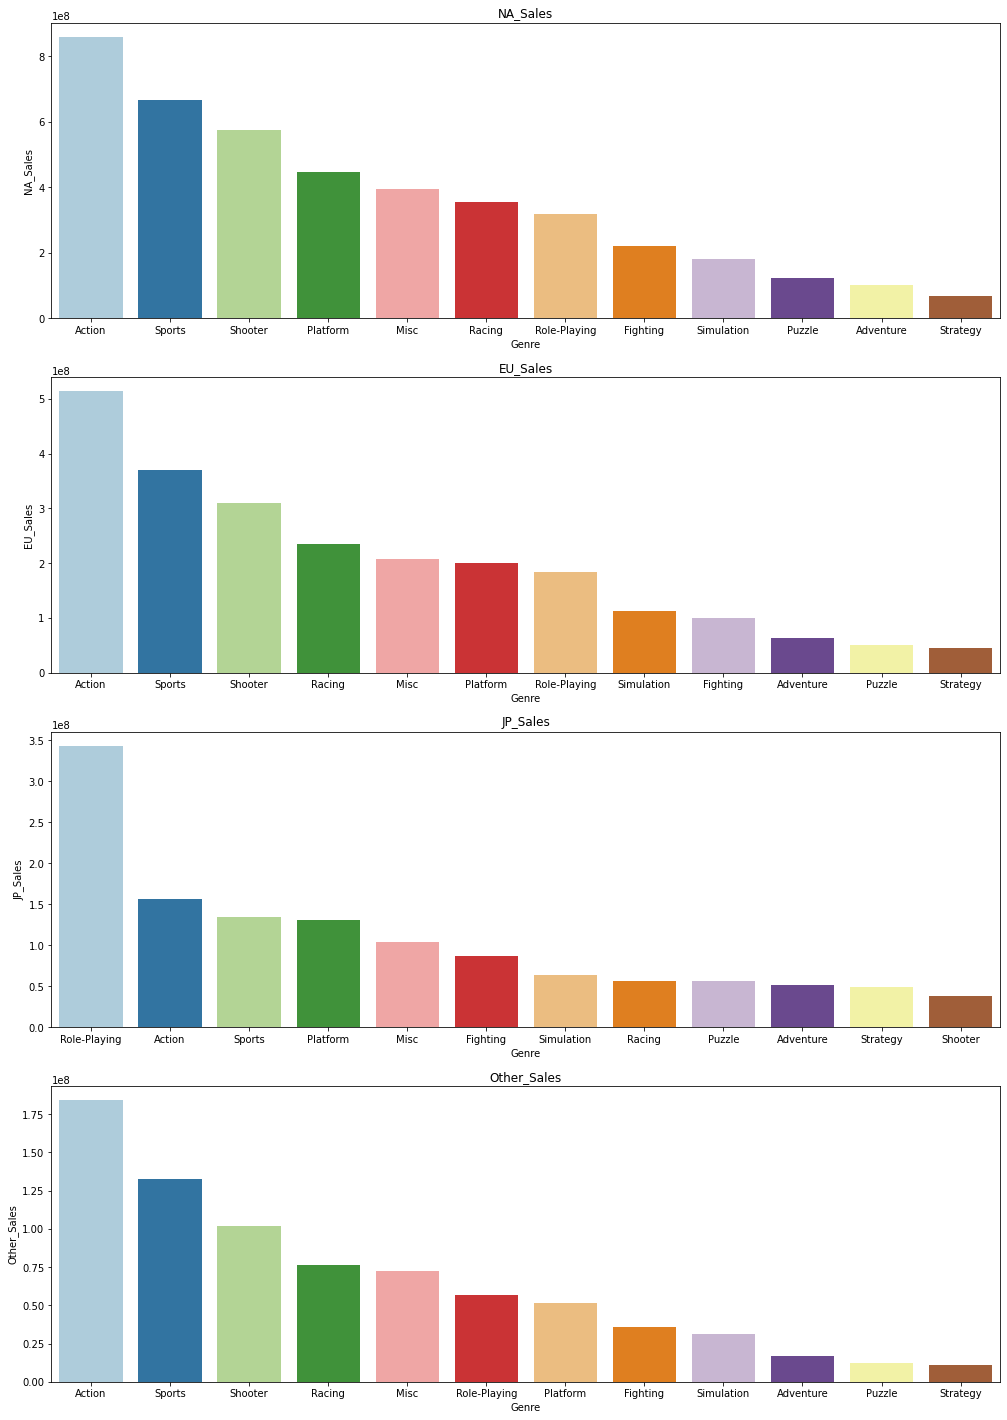

In [ ]:
fig = plt.figure(figsize=(17, 25))
ax = fig.add_subplot(4,1,1)
plt.title("NA_Sales")
sns.barplot(data=df_Genre_NA, x="Genre", y="NA_Sales", palette="Paired")

ax = fig.add_subplot(4,1,2)
plt.title("EU_Sales")
sns.barplot(data=df_Genre_EU, x="Genre", y="EU_Sales", palette="Paired")

ax = fig.add_subplot(4,1,3)
plt.title("JP_Sales")
sns.barplot(data=df_Genre_JP, x="Genre", y="JP_Sales", palette="Paired")

ax = fig.add_subplot(4,1,4)
plt.title("Other_Sales")
sns.barplot(data=df_Genre_Oth, x="Genre", y="Other_Sales", palette="Paired")

### 5.3 지역별 최근 10년 장르 TOP (DataFrame)

#####5.3.1 북미 게임 장르 순위

In [ ]:
df_Genre_NA_bar_top = df[df["Year"]>=2010].groupby(["Genre"])["NA_Sales"].sum().reset_index(drop=False)
df_Genre_NA_bar_top = df_Genre_NA_bar_top.sort_values(by=["NA_Sales"], ascending=[False]).reset_index(drop=True)
df_Genre_NA_bar_top

,Genre,NA_Sales
0,Action,286399999
1,Shooter,227629999
2,Sports,154029999
3,Misc,123229999
4,Role-Playing,102400000
5,Platform,55470000
6,Racing,45620000
7,Fighting,38560000
8,Simulation,26689999
9,Adventure,20640000


#####5.3.2 유럽 게임 장르 순위

In [ ]:
df_Genre_EU_bar_top = df[df["Year"]>=2010].groupby(["Genre"])["EU_Sales"].sum().reset_index(drop=False)
df_Genre_EU_bar_top = df_Genre_EU_bar_top.sort_values(by=["EU_Sales"], ascending=[False]).reset_index(drop=True)
df_Genre_EU_bar_top

,Genre,EU_Sales
0,Action,234989999
1,Shooter,166439997
2,Sports,115630000
3,Role-Playing,69699999
4,Misc,64420000
5,Racing,55509999
6,Platform,38670000
7,Simulation,25200000
8,Fighting,20770000
9,Adventure,19070000


#####5.3.3 일본 게임 장르 순위

In [ ]:
df_Genre_JP_bar_top = df[df["Year"]>=2010].groupby(["Genre"])["JP_Sales"].sum().reset_index(drop=False)
df_Genre_JP_bar_top = df_Genre_JP_bar_top.sort_values(by=["JP_Sales"], ascending=[False]).reset_index(drop=True)
df_Genre_JP_bar_top

,Genre,JP_Sales
0,Role-Playing,96100000
1,Action,70380000
2,Misc,21450000
3,Platform,15750000
4,Sports,15340000
5,Adventure,15300000
6,Fighting,13750000
7,Shooter,13540000
8,Simulation,13200000
9,Racing,6650000


#####5.3.4 기타 게임 장르 순위

In [ ]:
df_Genre_Oth_bar_top = df[df["Year"]>=2010].groupby(["Genre"])["Other_Sales"].sum().reset_index(drop=False)
df_Genre_Oth_bar_top = df_Genre_Oth_bar_top.sort_values(by=["Other_Sales"], ascending=[False]).reset_index(drop=True)
df_Genre_Oth_bar_top

,Genre,Other_Sales
0,Action,77829998
1,Shooter,55030000
2,Sports,39280000
3,Role-Playing,23090000
4,Misc,20200000
5,Racing,15860000
6,Platform,10840000
7,Fighting,8450000
8,Simulation,6000000
9,Adventure,5840000


### 5.4 지역별 최근 10년 장르 Top (Barplot)

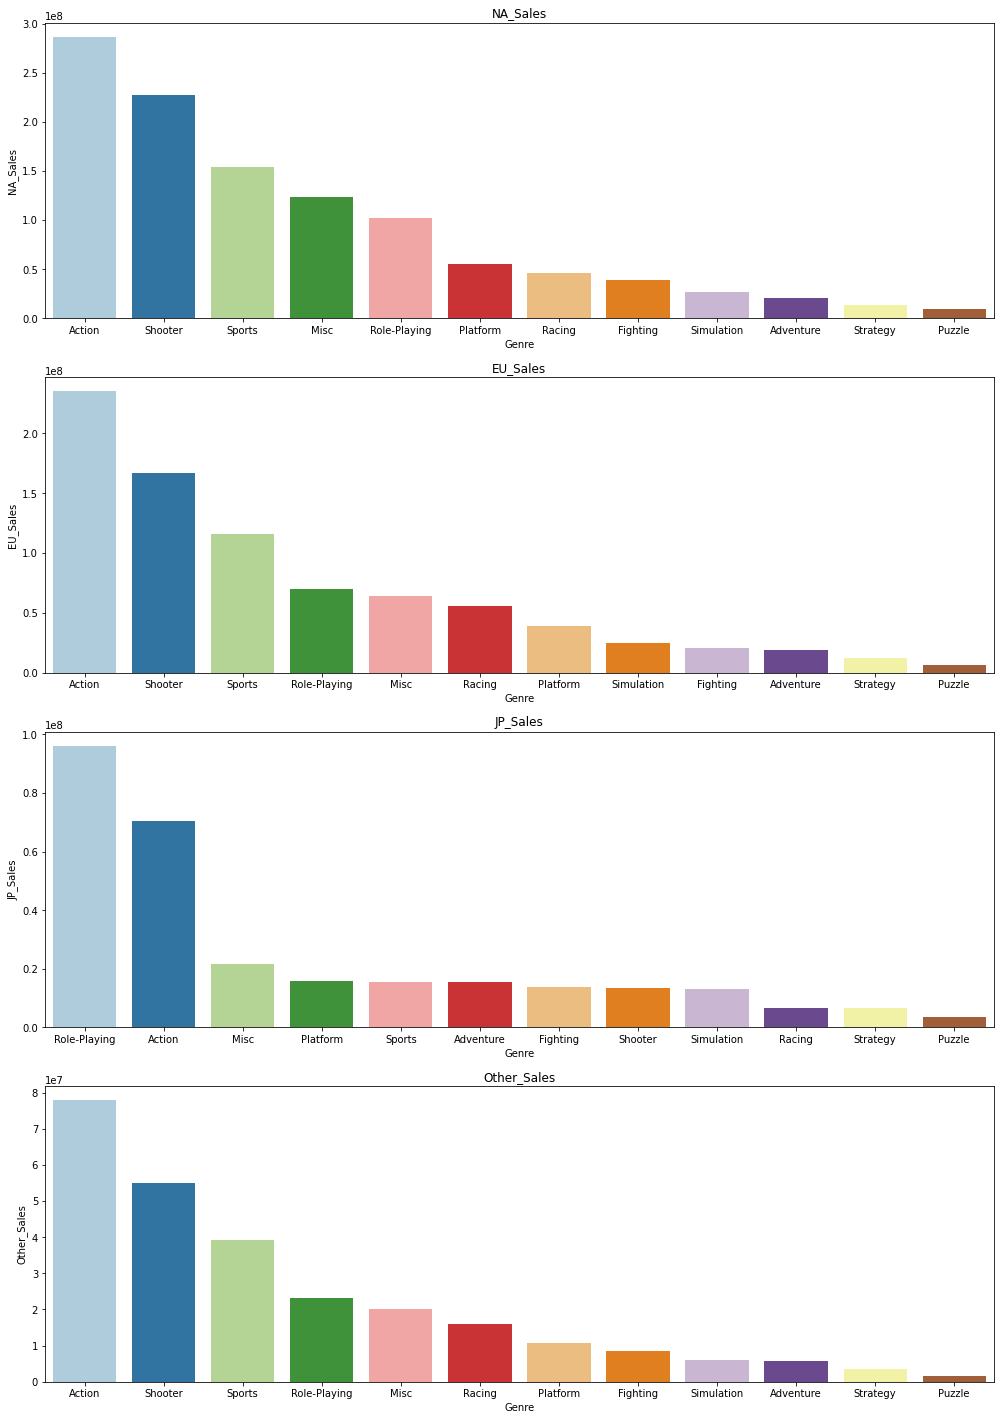

In [ ]:
fig = plt.figure(figsize=(17, 25))
ax = fig.add_subplot(4,1,1)
plt.title("NA_Sales")
sns.barplot(data=df_Genre_NA_bar_top, x="Genre", y="NA_Sales", palette="Paired")

ax = fig.add_subplot(4,1,2)
plt.title("EU_Sales")
sns.barplot(data=df_Genre_EU_bar_top, x="Genre", y="EU_Sales", palette="Paired")

ax = fig.add_subplot(4,1,3)
plt.title("JP_Sales")
sns.barplot(data=df_Genre_JP_bar_top, x="Genre", y="JP_Sales", palette="Paired")

ax = fig.add_subplot(4,1,4)
plt.title("Other_Sales")
sns.barplot(data=df_Genre_Oth_bar_top, x="Genre", y="Other_Sales", palette="Paired")

### 5.4 지역별 전체 연도, 최근 10년 장르 선호 변화 (Subplot)

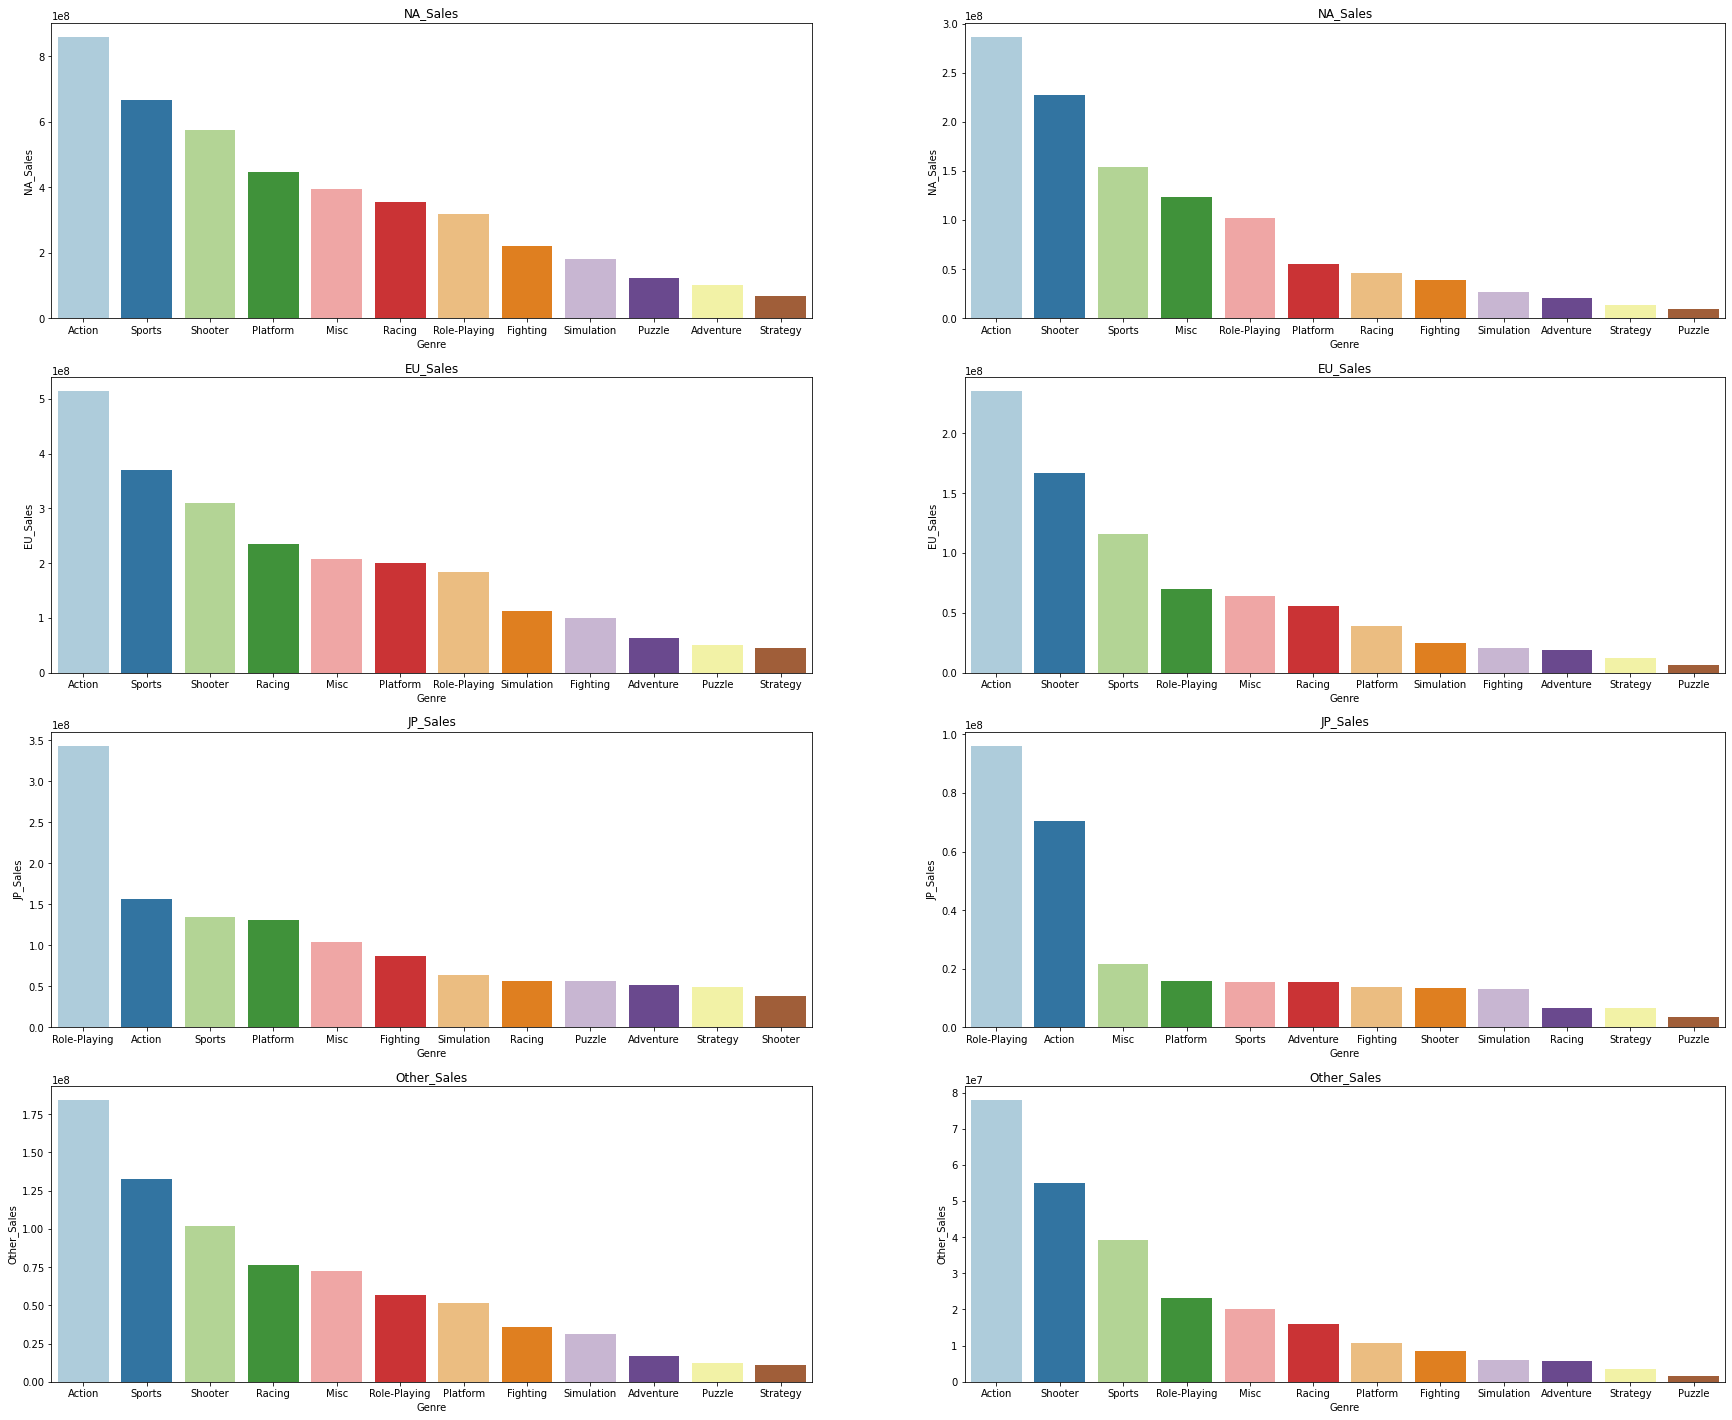

In [ ]:
fig = plt.figure(figsize=(30, 25))
ax = fig.add_subplot(4,2,1)
plt.title("NA_Sales")
sns.barplot(data=df_Genre_NA, x="Genre", y="NA_Sales", palette="Paired")

ax = fig.add_subplot(4,2,2)
plt.title("NA_Sales")
sns.barplot(data=df_Genre_NA_bar_top, x="Genre", y="NA_Sales", palette="Paired")

ax = fig.add_subplot(4,2,3)
plt.title("EU_Sales")
sns.barplot(data=df_Genre_EU, x="Genre", y="EU_Sales", palette="Paired")

ax = fig.add_subplot(4,2,4)
plt.title("EU_Sales")
sns.barplot(data=df_Genre_EU_bar_top, x="Genre", y="EU_Sales", palette="Paired")

ax = fig.add_subplot(4,2,5)
plt.title("JP_Sales")
sns.barplot(data=df_Genre_JP, x="Genre", y="JP_Sales", palette="Paired")

ax = fig.add_subplot(4,2,6)
plt.title("JP_Sales")
sns.barplot(data=df_Genre_JP_bar_top, x="Genre", y="JP_Sales", palette="Paired")

ax = fig.add_subplot(4,2,7)
plt.title("Other_Sales")
sns.barplot(data=df_Genre_Oth, x="Genre", y="Other_Sales", palette="Paired")

ax = fig.add_subplot(4,2,8)
plt.title("Other_Sales")
sns.barplot(data=df_Genre_Oth_bar_top, x="Genre", y="Other_Sales", palette="Paired")

#**6. 연도별 게임 트렌드가 있을까**

### 6.1 전체 연도 게임 트렌드 Top 4 (DataFrame)

##### 6.1.1 전체 연도 장르 트렌드 Top 4 (DataFrame)

In [ ]:
df_year_genre = df.groupby(["Year", "Genre"]).sum()["Total_Sales"].reset_index(drop=False)
df_year_genre = df_year_genre.sort_values(by=["Year", "Total_Sales"], ascending=[True, False]).reset_index(drop=True)
years = np.sort(df_year_genre["Year"].unique())

year_genre = {}
for y in years:
    year_genre[y] = df_year_genre[df_year_genre["Year"]==y][:4]["Genre"].tolist()
year_genre

df_year_genre_top = pd.DataFrame(year_genre.values(), year_genre.keys(), columns=["top1", "top2", "top3", "top4"])
df_year_genre_top

,top1,top2,top3,top4
1980,Shooter,Misc,Fighting,Action
1981,Action,Shooter,Platform,Puzzle
1982,Puzzle,Action,Platform,Shooter
1983,Platform,Sports,Action,Misc
1984,Shooter,Sports,Racing,Puzzle
1985,Platform,Action,Puzzle,Sports
1986,Action,Platform,Sports,Shooter
1987,Fighting,Role-Playing,Adventure,Sports
1988,Platform,Role-Playing,Puzzle,Sports
1989,Puzzle,Platform,Sports,Action


##### 6.1.2 전체 연도 장르 트렌드 (Plot)

In [ ]:
df_Genre_Total = df.groupby(["Genre"])["Total_Sales"].sum().reset_index(drop=False)
df_Genre_Total = df_Genre_Total.sort_values(by=["Total_Sales"], ascending=[False]).reset_index(drop=True)
df_Genre_Total

,Genre,Total_Sales
0,Action,1712979992
1,Sports,1305339993
2,Shooter,1024749993
3,Role-Playing,901509996
4,Platform,827989997
5,Misc,779699998
6,Racing,722549996
7,Fighting,443539998
8,Simulation,389279998
9,Puzzle,240729999


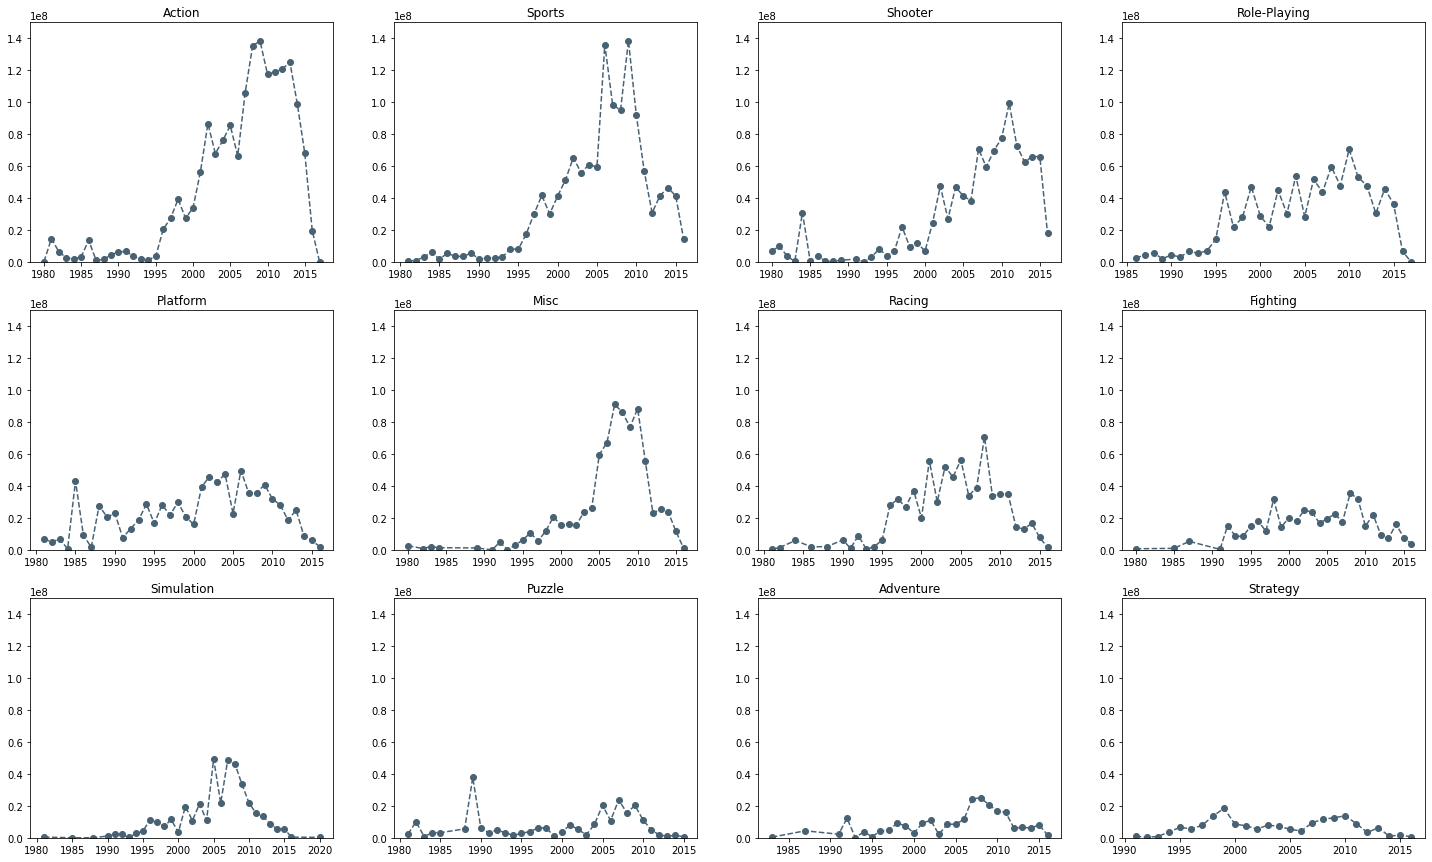

In [ ]:
genres = df_Genre_Total["Genre"].unique()

fig=plt.figure(figsize=(25,15))
for i, genre in enumerate(genres):
    df_action = df[df["Genre"] == genre]
    df_action = df_action.groupby("Year")["Total_Sales"].sum().reset_index(drop=False)
    ax = fig.add_subplot(3,4,i+1)
    plt.plot(df_action["Year"], df_action["Total_Sales"], color="#486273", marker='o', linestyle='--')
    plt.ylim(0, 150000000)
    plt.title(genre)

##### 6.1.3 전체 연도 플랫폼 트렌드 Top 4 (DateFrame)

In [ ]:
df_year_platform = df.groupby(["Year", "Platform"]).sum()["Total_Sales"].reset_index(drop=False)
df_year_platform = df_year_platform.sort_values(by=["Year", "Total_Sales"], ascending=[True, False]).reset_index(drop=True)
years = np.sort(df_year_platform["Year"].unique())

year_platform = {}
for y in years:
    year_platform[y] = df_year_platform[df_year_platform["Year"]==y][:4]["Platform"].tolist()
year_platform

df_year_platform_top = pd.DataFrame(year_platform.values(), year_platform.keys(), columns=["top1", "top2", "top3", "top4"])
df_year_platform_top

,top1,top2,top3,top4
1980,2600,None,None,None
1981,2600,None,None,None
1982,2600,None,None,None
1983,NES,2600,None,None
1984,NES,2600,None,None
1985,NES,2600,PC,DS
1986,NES,2600,None,None
1987,NES,2600,None,None
1988,NES,GB,2600,PC
1989,GB,NES,2600,None


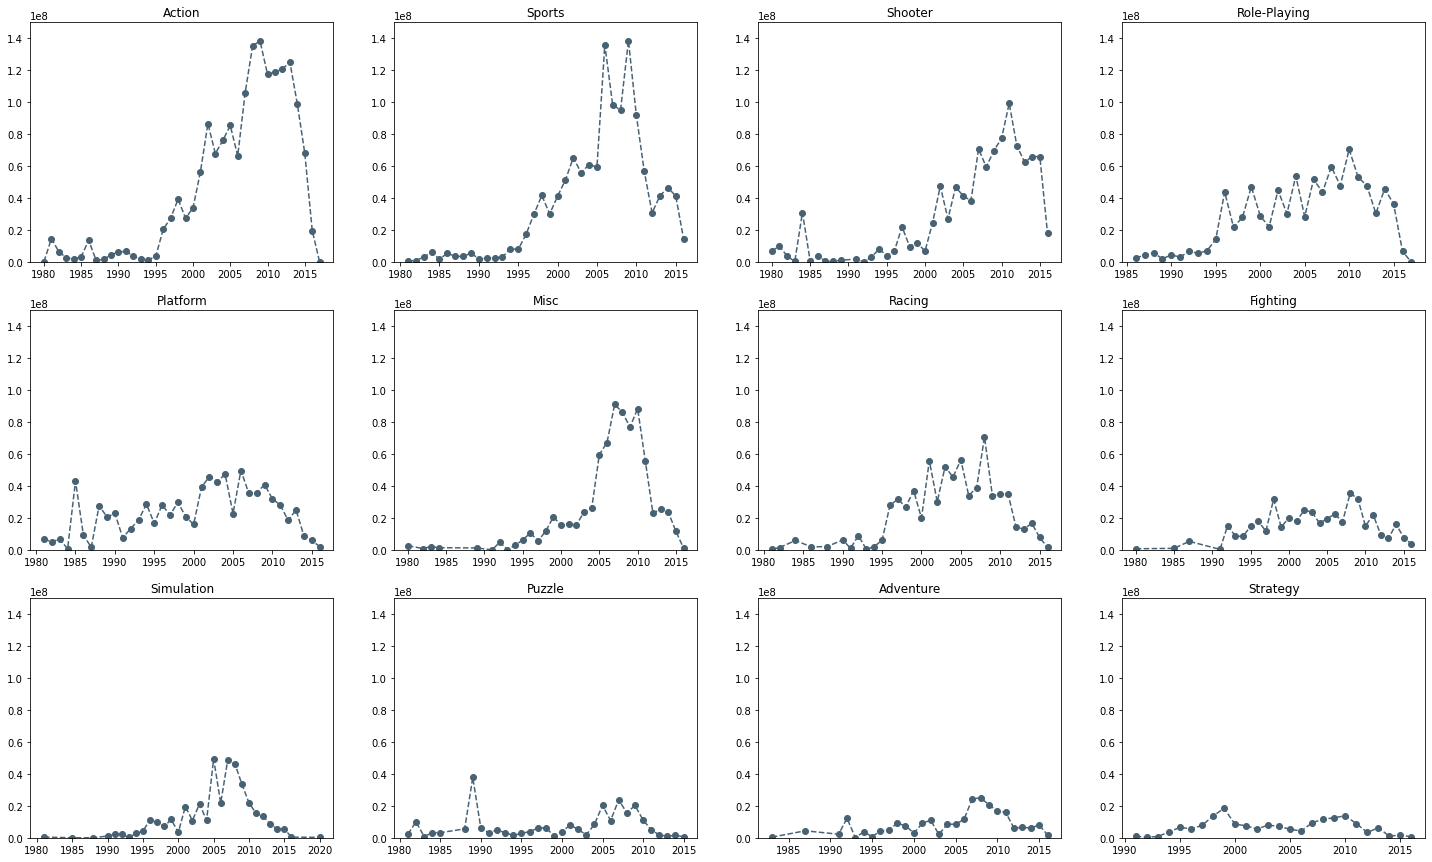

In [ ]:
genres = df_Genre_Total["Genre"].unique()

fig=plt.figure(figsize=(25,15))
for i, genre in enumerate(genres):
    df_action = df[df["Genre"] == genre]
    df_action = df_action.groupby("Year")["Total_Sales"].sum().reset_index(drop=False)
    ax = fig.add_subplot(3,4,i+1)
    plt.plot(df_action["Year"], df_action["Total_Sales"], color="#486273", marker='o', linestyle='--')
    plt.ylim(0, 150000000)
    plt.title(genre)

##### 6.1.4 전체 연도 회사 트렌드 Top 4 (DataFrame)

In [ ]:
df_year_Publisher = df.groupby(["Year", "Publisher"]).sum()["Total_Sales"].reset_index(drop=False)
df_year_Publisher = df_year_Publisher.sort_values(by=["Year", "Total_Sales"], ascending=[True, False]).reset_index(drop=True)
years = np.sort(df_year_Publisher["Year"].unique())

year_Publisher = {}
for y in years:
    year_Publisher[y] = df_year_Publisher[df_year_Publisher["Year"]==y][:4]["Publisher"].tolist()
year_Publisher

df_year_Publisher_top = pd.DataFrame(year_Publisher.values(), year_Publisher.keys(), columns=["top1", "top2", "top3", "top4"])
df_year_Publisher_top

,top1,top2,top3,top4
1980,Atari,Activision,None,None
1981,Activision,Atari,Imagic,Parker Bros.
1982,Atari,Activision,Parker Bros.,Quelle
1983,Nintendo,Atari,Activision,Parker Bros.
1984,Nintendo,Namco Bandai Games,Hudson Soft,Activision
1985,Nintendo,Namco Bandai Games,Hudson Soft,Capcom
1986,Nintendo,Capcom,Namco Bandai Games,Konami Digital Entertainment
1987,Nintendo,Namco Bandai Games,Enix Corporation,Activision
1988,Nintendo,Enix Corporation,Capcom,Namco Bandai Games
1989,Nintendo,Palcom,Capcom,Namco Bandai Games


### 6.2 최근 10년 게임 트렌드 Top 4

##### 6.2.1 최근 10년 장르 트렌드 Top 4 (DataFrame)

In [ ]:
df_year10_genre = df[df["Year"]>=2010].groupby(["Year", "Genre"]).sum()["Total_Sales"].reset_index(drop=False)
df_year10_genre = df_year10_genre.sort_values(by=["Year", "Total_Sales"], ascending=[True, False]).reset_index(drop=True)
years = np.sort(df_year10_genre["Year"].unique())

year10_genre = {}
for y in years:
    year10_genre[y] = df_year10_genre[df_year10_genre["Year"]==y][:4]["Genre"].tolist()
year10_genre

df_year10_genre_top = pd.DataFrame(year10_genre.values(), year10_genre.keys(), columns=["top1", "top2", "top3", "top4"])
df_year10_genre_top

,top1,top2,top3,top4
2010,Action,Sports,Misc,Shooter
2011,Action,Shooter,Sports,Misc
2012,Action,Shooter,Role-Playing,Sports
2013,Action,Shooter,Sports,Role-Playing
2014,Action,Shooter,Sports,Role-Playing
2015,Action,Shooter,Sports,Role-Playing
2016,Action,Shooter,Sports,Role-Playing
2017,Role-Playing,Action,None,None
2020,Simulation,None,None,None


##### 6.2.2 최근 10년 장르 트렌드 (Plot)

In [ ]:
df_year_10 = df[df["Year"]>=2010]
df_Genre_Total_10 = df_year_10.groupby(["Genre"])["Total_Sales"].sum().reset_index(drop=False)
df_Genre_Total_10 = df_Genre_Total_10.sort_values(by=["Total_Sales"], ascending=[False]).reset_index(drop=True)
df_Genre_Total_10

,Genre,Total_Sales
0,Action,669599996
1,Shooter,462639996
2,Sports,324279999
3,Role-Playing,291289999
4,Misc,229299999
5,Racing,123639999
6,Platform,120730000
7,Fighting,81530000
8,Simulation,71089999
9,Adventure,60850000


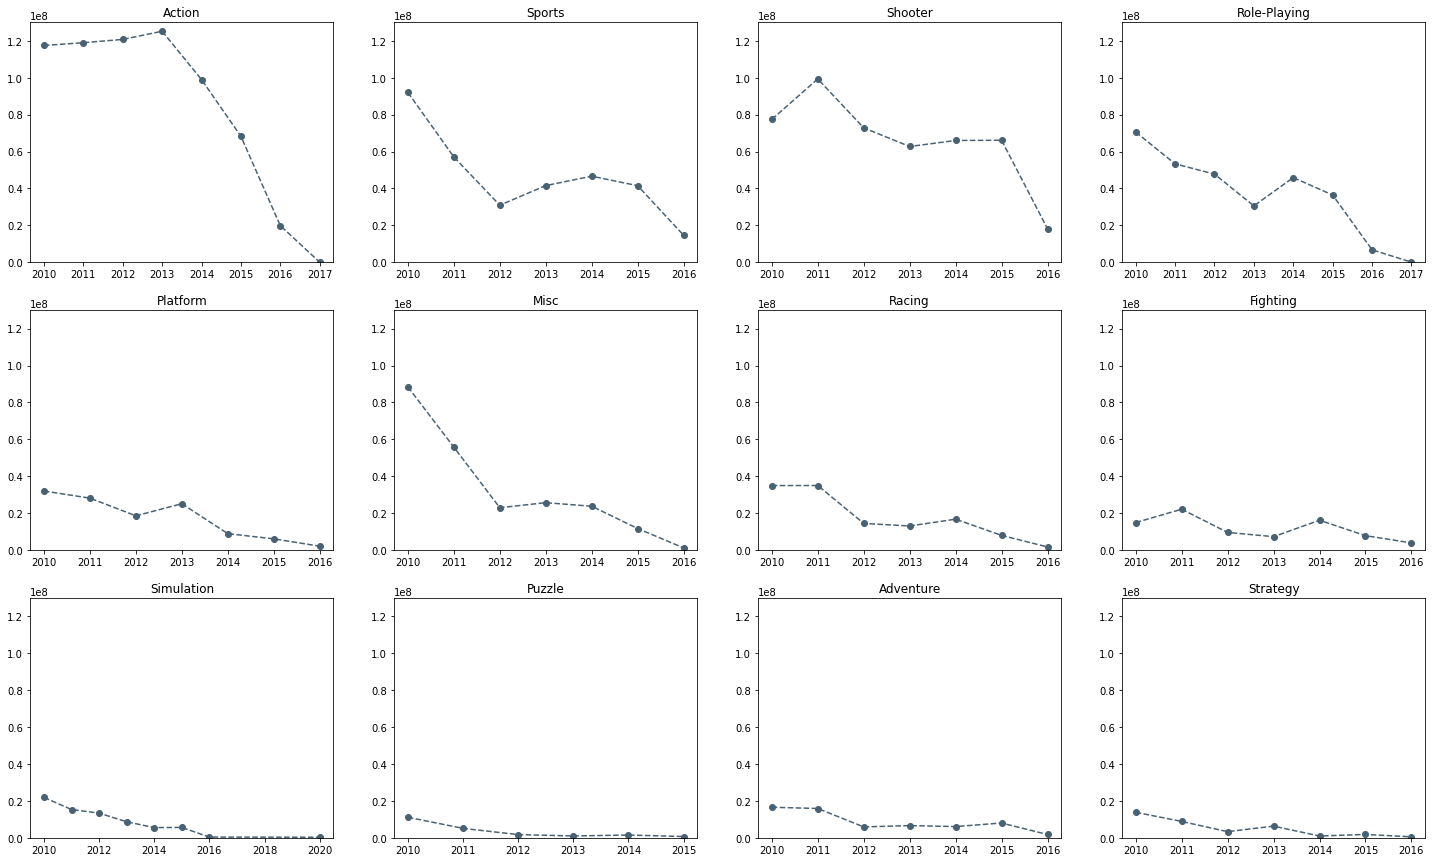

In [ ]:
genres_top10 = df_Genre_Total_10["Genre"].unique()
fig=plt.figure(figsize=(25,15))
for i, genre in enumerate(genres):
    df_action = df_year_10[df_year_10["Genre"] == genre]
    df_action = df_action.groupby("Year")["Total_Sales"].sum().reset_index(drop=False)
    ax = fig.add_subplot(3,4,i+1)
    plt.plot(df_action["Year"], df_action["Total_Sales"], color="#486273", marker='o', linestyle='--')
    plt.title(genre)
    plt.ylim(0, 130000000)

##### 6.2.3 최근 10년 플랫폼 트렌드 Top 4 (DataFrame)

In [ ]:
df_year10_platform = df[df["Year"]>=2010].groupby(["Year", "Platform"]).sum()["Total_Sales"].reset_index(drop=False)
df_year10_platform = df_year10_platform.sort_values(by=["Year", "Total_Sales"], ascending=[True, False]).reset_index(drop=True)
years = np.sort(df_year10_platform["Year"].unique())

year10_platform = {}
for y in years:
    year10_platform[y] = df_year_platform[df_year_platform["Year"]==y][:4]["Platform"].tolist()
year10_platform

df_year10_platform_top = pd.DataFrame(year10_platform.values(), year10_platform.keys(), columns=["top1", "top2", "top3", "top4"])
df_year10_platform_top

,top1,top2,top3,top4
2010,X360,PS3,Wii,DS
2011,PS3,X360,3DS,Wii
2012,PS3,X360,3DS,PC
2013,PS3,X360,3DS,PS4
2014,PS4,XOne,PS3,3DS
2015,PS4,XOne,3DS,PS3
2016,PS4,XOne,3DS,PSV
2017,PS4,PSV,None,None
2020,DS,None,None,None


##### 6.2.4 최근 10년 회사 트렌드 Top 4 (DataFrame)

In [ ]:
df_year10_Publisher = df[df["Year"]>=2010].groupby(["Year", "Publisher"]).sum()["Total_Sales"].reset_index(drop=False)
df_year10_Publisher = df_year10_Publisher.sort_values(by=["Year", "Total_Sales"], ascending=[True, False]).reset_index(drop=True)
years = np.sort(df_year10_Publisher["Year"].unique())

year10_Publisher = {}
for y in years:
    year10_Publisher[y] = df_year10_Publisher[df_year10_Publisher["Year"]==y][:4]["Publisher"].tolist()
year10_Publisher

df_year10_Publisher_top = pd.DataFrame(year10_Publisher.values(), year10_Publisher.keys(), columns=["top1", "top2", "top3", "top4"])
df_year10_Publisher_top

,top1,top2,top3,top4
2010,Electronic Arts,Activision,Nintendo,Microsoft Game Studios
2011,Electronic Arts,Activision,Nintendo,Ubisoft
2012,Nintendo,Activision,Electronic Arts,Ubisoft
2013,Electronic Arts,Take-Two Interactive,Activision,Nintendo
2014,Nintendo,Electronic Arts,Activision,Ubisoft
2015,Electronic Arts,Activision,Nintendo,Warner Bros. Interactive Entertainment
2016,Electronic Arts,Ubisoft,Sony Computer Entertainment,Namco Bandai Games
2017,Sega,Idea Factory,None,None
2020,Ubisoft,None,None,None


#**7. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스**

### 7.1 전체 연도 게임 출고량 Top (DataFrame)

##### 7.1.1 북미 게임 출고량 순위

In [ ]:
df_name_all = df.groupby(["Name", "Genre", "Publisher"])["Total_Sales"].sum().reset_index(drop=False)
df_name_all = df_name_all.sort_values(by=["Total_Sales"], ascending=[False]).reset_index(drop=True)
df_name_all_top10 = df_name_all.iloc[:10]
df_name_all_top10

,Name,Genre,Publisher,Total_Sales
0,Wii Sports,Sports,Nintendo,82740000
1,Grand Theft Auto V,Action,Take-Two Interactive,55919998
2,Super Mario Bros.,Platform,Nintendo,45310000
3,Tetris,Puzzle,Nintendo,35840000
4,Mario Kart Wii,Racing,Nintendo,35830000
5,Wii Sports Resort,Sports,Nintendo,33000000
6,Pokemon Red/Pokemon Blue,Role-Playing,Nintendo,31380000
7,Call of Duty: Modern Warfare 3,Shooter,Activision,30840000
8,New Super Mario Bros.,Platform,Nintendo,30010000
9,Call of Duty: Black Ops II,Shooter,Activision,29730000


##### 7.1.2 유럽 게임 출고량 순위

In [ ]:
df_name_NA = df.groupby(["Name", "Genre", "Publisher"])["NA_Sales"].sum().reset_index(drop=False)
df_name_NA = df_name_NA.sort_values(by=["NA_Sales"], ascending=[False]).reset_index(drop=True)
df_name_NA_top10 = df_name_NA.iloc[:10]
df_name_NA_top10

,Name,Genre,Publisher,NA_Sales
0,Wii Sports,Sports,Nintendo,41490000
1,Super Mario Bros.,Platform,Nintendo,32480000
2,Duck Hunt,Shooter,Nintendo,26930000
3,Tetris,Puzzle,Nintendo,26170000
4,Grand Theft Auto V,Action,Take-Two Interactive,23460000
5,Call of Duty: Black Ops,Shooter,Activision,17010000
6,Super Mario World,Platform,Nintendo,15990000
7,Mario Kart Wii,Racing,Nintendo,15850000
8,Wii Sports Resort,Sports,Nintendo,15750000
9,Call of Duty: Modern Warfare 3,Shooter,Activision,15580000


##### 7.1.3 일본 게임 출고량 순위

In [ ]:
df_name_EU = df.groupby(["Name", "Genre", "Publisher"])["EU_Sales"].sum().reset_index(drop=False)
df_name_EU = df_name_EU.sort_values(by=["EU_Sales"], ascending=[False]).reset_index(drop=True)
df_name_EU_top10 = df_name_EU.iloc[:10]
df_name_EU_top10

,Name,Genre,Publisher,EU_Sales
0,Wii Sports,Sports,Nintendo,29020000
1,Grand Theft Auto V,Action,Take-Two Interactive,23039999
2,Mario Kart Wii,Racing,Nintendo,12880000
3,FIFA 15,Sports,Electronic Arts,12400000
4,FIFA 16,Sports,Electronic Arts,11290000
5,Call of Duty: Modern Warfare 3,Shooter,Activision,11290000
6,FIFA 14,Sports,Electronic Arts,11140000
7,Call of Duty: Black Ops II,Shooter,Activision,11050000
8,Wii Sports Resort,Sports,Nintendo,11010000
9,Nintendogs,Simulation,Nintendo,11000000


##### 7.1.4 기타 게임 출고량 순위

In [ ]:
df_name_Oth = df.groupby(["Name", "Genre", "Publisher"])["Other_Sales"].sum().reset_index(drop=False)
df_name_Oth = df_name_Oth.sort_values(by=["Other_Sales"], ascending=[False]).reset_index(drop=True)
df_name_Oth_top10 = df_name_Oth.iloc[:10]
df_name_Oth_top10

,Name,Genre,Publisher,Other_Sales
0,Grand Theft Auto: San Andreas,Action,Take-Two Interactive,10720000
1,Wii Sports,Sports,Nintendo,8460000
2,Grand Theft Auto V,Action,Take-Two Interactive,8029999
3,Gran Turismo 4,Racing,Sony Computer Entertainment,7530000
4,Call of Duty: Black Ops II,Shooter,Activision,3880000
5,FIFA Soccer 08,Sports,Electronic Arts,3530000
6,Pro Evolution Soccer 2008,Sports,Konami Digital Entertainment,3510000
7,Call of Duty: Black Ops 3,Shooter,Activision,3420000
8,Call of Duty: Modern Warfare 3,Shooter,Activision,3350000
9,Mario Kart Wii,Racing,Nintendo,3310000


### 7.2 전체 연도 게임 출고량 Top (Plt)

In [ ]:
df_Sales = df.groupby(["Name"])["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Total_Sales"].sum().reset_index(drop=False)
df_Sales = df_Sales.sort_values(by=["Total_Sales"], ascending=[False]).reset_index(drop=True)
df_Sales = df_Sales.iloc[:10]
df_Sales

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Name,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Wii Sports,41490000,29020000,3770000,8460000,82740000
1,Grand Theft Auto V,23460000,23039999,1390000,8029999,55919998
2,Super Mario Bros.,32480000,4880000,6960000,990000,45310000
3,Tetris,26170000,2950000,6030000,690000,35840000
4,Mario Kart Wii,15850000,12880000,3790000,3310000,35830000
5,Wii Sports Resort,15750000,11010000,3280000,2960000,33000000
6,Pokemon Red/Pokemon Blue,11270000,8890000,10220000,1000000,31380000
7,Call of Duty: Modern Warfare 3,15580000,11290000,620000,3350000,30840000
8,New Super Mario Bros.,11380000,9230000,6500000,2900000,30010000
9,Call of Duty: Black Ops II,14080000,11050000,720000,3880000,29730000


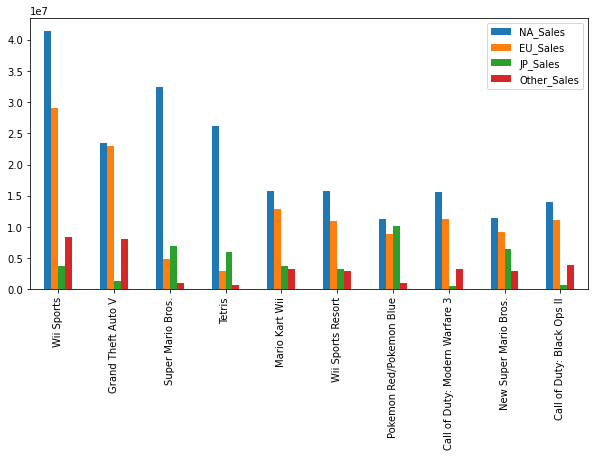

<Figure size 432x288 with 0 Axes>

In [ ]:
list(df_Sales["Name"])
['Wii Sports','Grand Theft Auto V','Super Mario Bros.','Tetris','Mario Kart Wii','Wii Sports Resort','Pokemon Red/Pokemon Blue','Call of Duty: Modern Warfare 3','New Super Mario Bros.','Call of Duty: Black Ops II']
df_Sales.iloc[:, :5].plot(kind="bar", figsize=(10, 5))
X = list(range(10))
ticklabel = df_Sales["Name"]
plt.xticks(X, ticklabel)
plt.show()

### 7.3 최근 10년 게임 출고량 Top (Plot)

In [ ]:
df_Sales = df[df["Year"]>=2010].groupby(["Name"])["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Total_Sales"].sum().reset_index(drop=False)
df_Sales = df_Sales.sort_values(by=["Total_Sales"], ascending=[False]).reset_index(drop=True)
df_Sales = df_Sales.iloc[:10]
df_Sales

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Name,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Grand Theft Auto V,23460000,23039999,1390000,8029999,55919998
1,Call of Duty: Modern Warfare 3,15580000,11290000,620000,3350000,30840000
2,Call of Duty: Black Ops II,14080000,11050000,720000,3880000,29730000
3,Call of Duty: Black Ops,17010000,8690000,590000,3120000,29410000
4,Call of Duty: Ghosts,14920000,9050000,480000,2920000,27370000
5,Call of Duty: Black Ops 3,11890000,9559999,430000,3420000,25299999
6,Minecraft,10820000,8850000,1150000,2930000,23750000
7,Call of Duty: Advanced Warfare,10440000,8180000,340000,2930000,21890000
8,Kinect Adventures!,14970000,4940000,240000,1670000,21820000
9,The Elder Scrolls V: Skyrim,8730000,7659999,350000,2540000,19279999


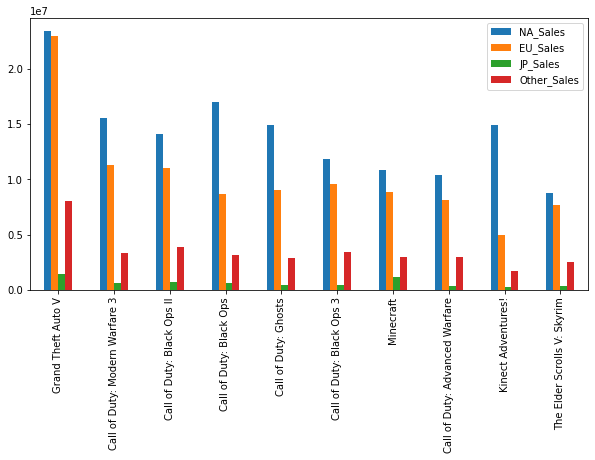

<Figure size 432x288 with 0 Axes>

In [ ]:
list(df_Sales["Name"])
['Wii Sports','Grand Theft Auto V','Super Mario Bros.','Tetris','Mario Kart Wii','Wii Sports Resort','Pokemon Red/Pokemon Blue','Call of Duty: Modern Warfare 3','New Super Mario Bros.','Call of Duty: Black Ops II']
df_Sales.iloc[:, :5].plot(kind="bar", figsize=(10, 5))
X = list(range(10))
ticklabel = df_Sales["Name"]
plt.xticks(X, ticklabel)
plt.show()

### 7.4 중복 처리 안한 이유

* Platform은 groupby 조건에서 제거 했는데 Publisher는 제거하지 않은 이유 :<br> 중복치 존재 데이터가 확인하려는 데이터 순위 밖의 것으로 유의미하지 않아 무시하고 작업

In [ ]:
df_name_all[df_name_all["Name"].duplicated()]

,Name,Genre,Publisher,Total_Sales
210,Minecraft,Misc,Sony Computer Entertainment Europe,6280000
268,Minecraft,Misc,Sony Computer Entertainment,5420000
347,The Last of Us,Action,Sony Computer Entertainment,4540000
481,Monopoly,Misc,Electronic Arts,3580000
572,The Elder Scrolls IV: Oblivion,Role-Playing,Ubisoft,3120000
...,...,...,...,...
11523,Sea Monsters: A Prehistoric Adventure,Adventure,DSI Games,10000
11555,Time Travelers,Adventure,Level 5,10000
11559,Judge Dredd: Dredd Vs Death,Shooter,Vivendi Games,10000
11623,Puyo Pop Fever,Puzzle,Sega,10000


# 8. 결론

전체 연도의 장르가 Action - Sports - Shooter - Role playing 순이고 <br>
최근 10년 장르가 Action - Shooter - Sprots - Role Playing 순으로<br>
장르의 순위 변동은 적고 이미 주 장르가 정해져 있음을 알 수 있고,<br>
<br>

전체 연도의 게임이 wii sports - GTA - Super Mario Bros - Tetris처럼 다양하지만 <br>
최근 10년 게임이 GTA V - 6개 항목의 Call of Duty 시리즈인 걸 보아<br>
<br>

당사는 전체 연도에서 차이를 보이지 않고, <br>
최근 10년에 주로 출고되고 있는 GTA(Action) 또는 call of duty (Shooter) 같은 게임을 출시 하여야 합니다.